# PYMC GP Example
- From here: [PYMC3 Website](https://docs.pymc.io/notebooks/GP-MaunaLoa.html)
- Data link: https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/zipped_data_sets/mlo_station_data_set.zip


In [30]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
if Path('.').absolute().parents[0].name == 'gp_drought':
    os.chdir(Path('.').absolute().parents[0])

data_dir = Path('data')
assert data_dir.exists()

print("Current Directory: ", os.getcwd())

Current Directory:  /Users/tommylees/github/gp_drought


In [32]:
import theano.tensor as tt
import pymc3 as pm

# Clean the data

In [9]:
data_monthly = pd.read_csv(data_dir / "mlo/monthly_in_situ_co2_mlo.csv", header=56)

# - replace -99.99 with NaN
data_monthly.replace(to_replace=-99.99, value=np.nan, inplace=True)

# fix column names
cols = ["year", "month", "--", "--", "CO2", "seasonaly_adjusted", "fit",
        "seasonally_adjusted_fit", "CO2_filled", "seasonally_adjusted_filled"]
data_monthly.columns = cols
cols.remove("--"); cols.remove("--")
data_monthly = data_monthly[cols]

# drop rows with nan
data_monthly.dropna(inplace=True)

# fix time index
data_monthly["day"] = 15
data_monthly.index = pd.to_datetime(data_monthly[["year", "month", "day"]])
cols.remove("year"); cols.remove("month")
data_monthly = data_monthly[cols]

data_monthly.head(5)

,CO2,seasonaly_adjusted,fit,seasonally_adjusted_fit,CO2_filled,seasonally_adjusted_filled
1958-03-15,315.70,314.44,316.19,314.91,315.70,314.44
1958-04-15,317.45,315.16,317.30,314.99,317.45,315.16
1958-05-15,317.51,314.71,317.86,315.07,317.51,314.71
1958-07-15,315.86,315.19,315.86,315.22,315.86,315.19
1958-08-15,314.93,316.19,314.00,315.29,314.93,316.19


In [25]:
# function to convert datetimes to numbers that are useful to algorithms
#   this will be useful later when doing prediction

def dates_to_idx(timelist):
    reference_time = timelist.min()  # pd.to_datetime('1958-03-15')
    t = (timelist - reference_time) / pd.Timedelta(365, "days")
    return np.asarray(t)

t = dates_to_idx(data_monthly.index)

# normalize CO2 levels
y = data_monthly["CO2"].values
first_co2 = y[0]
std_co2 = np.std(y)
y_n = (y - first_co2) / std_co2

data_monthly = data_monthly.assign(t = t)
data_monthly = data_monthly.assign(y_n = y_n)
data_monthly.head()

,CO2,seasonaly_adjusted,fit,seasonally_adjusted_fit,CO2_filled,seasonally_adjusted_filled,t,y_n
1958-03-15,315.70,314.44,316.19,314.91,315.70,314.44,0.000000,0.000000
1958-04-15,317.45,315.16,317.30,314.99,317.45,315.16,0.084932,0.061830
1958-05-15,317.51,314.71,317.86,315.07,317.51,314.71,0.167123,0.063950
1958-07-15,315.86,315.19,315.86,315.22,315.86,315.19,0.334247,0.005653
1958-08-15,314.93,316.19,314.00,315.29,314.93,316.19,0.419178,-0.027205


# Train test split (->2004, 2004->)

In [26]:
# split into training and test set
sep_idx = data_monthly.index.searchsorted(pd.to_datetime("2003-12-15"))

data_early = data_monthly.iloc[:sep_idx+1, :]
data_later = data_monthly.iloc[sep_idx:, :]

data_early = data_monthly.loc[:'2003']
data_later = data_monthly.loc['2004':]

# Plot the data
- 400 ppm level is highlighted with a dashed line
- Target: when do we first reach 400ppm? (Answer = March 2013)

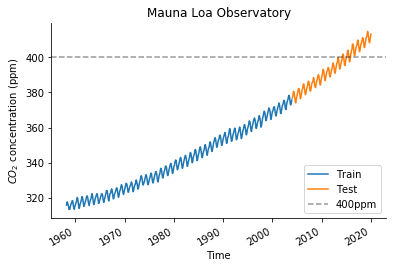

In [27]:
fig, ax = plt.subplots()
data_early['CO2'].plot(ax=ax, label='Train')
data_later['CO2'].plot(ax=ax, label='Test')

ax.axhline(400, color='k', alpha=0.4, ls='--', label='400ppm')

ax.set_xlabel('Time')
ax.set_ylabel('$CO_2$ concentration (ppm)')
ax.set_title('Mauna Loa Observatory')
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Modelling using GP
The R+W model is a sum of three GPs for the signal, and one GP for the noise.

1. A *long term smooth rising trend* represented by an **exponentiated quadratic kernel**
1. A *periodic term* that decays away from exact periodicity. This is represented by the **product of a Periodic covariance function and an exponentiated quadratic**.
1. *Small and medium term irregularities* with a **rational quadratic kernel**.
1. The *noise* is modeled as the **sum of an Exponential and a white noise kernel**

$$
f(t) \sim \mathcal{GP}_{\text{slow}}(0,\, k_1(t, t')) +
          \mathcal{GP}_{\text{med}}(0,\,  k_2(t, t')) +
          \mathcal{GP}_{\text{per}}(0,\,  k_3(t, t')) +
          \mathcal{GP}_{\text{noise}}(0,\,  k_n(t, t'))
$$

## Lengthscale + Period Paremeters

**ℓ_pdecay**: The periodic decay. The smaller this parameter is, the faster the periodicity goes away. I doubt that the seasonality of the CO2 will be going away any time soon (hopefully), and there’s no evidence for that in the data. Most of the prior mass is from 60 to >140 years.

**ℓ_psmooth**: The smoothness of the periodic component. It controls how “sinusoidal” the periodicity is. The plot of the data shows that seasonality is not an exact sine wave, but its not terribly different from one. We use a Gamma whose mode is at one, and doesn’t have too large of a variance, with most of the prior mass from around 0.5 and 2.

**period**: The period. We put a very strong prior on 𝑝, the period that is centered at one. R+W fix 𝑝=1, since the period is annual.

**ℓ_med**: This is the lengthscale for the short to medium long variations. This prior has most of its mass below 6 years.

**α**: This is the shape parameter. This prior is centered at 3, since we’re expecting there to be some more variation than could be explained by an exponentiated quadratic.

**ℓ_trend**: The lengthscale of the long term trend. It has a wide prior with mass on a decade scale. Most of the mass is between 10 to 60 years.

**ℓ_noise**: The lengthscale of the noise covariance. This noise should be very rapid, in the scale of several months to at most a year or two.



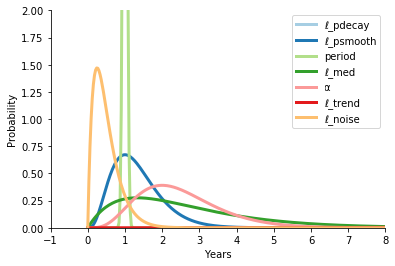

In [56]:
x = np.linspace(0, 150, 5000)
priors = [  # [0]=name, [1]=distribution
    ("ℓ_pdecay",  pm.Gamma.dist(alpha=10, beta=0.075)),
    ("ℓ_psmooth", pm.Gamma.dist(alpha=4,  beta=3)),
    ("period",    pm.Normal.dist(mu=1.0,  sigma=0.05)),
    ("ℓ_med",     pm.Gamma.dist(alpha=2,  beta=0.75)),
    ("α",         pm.Gamma.dist(alpha=5,  beta=2)),
    ("ℓ_trend",   pm.Gamma.dist(alpha=4,  beta=0.1)),
    ("ℓ_noise",   pm.Gamma.dist(alpha=2,  beta=4))]

colors = sns.color_palette('Paired', 7)
fig, ax = plt.subplots()
x_range = (-1, 8)
y_range = (0, 2)
ax.set_ylabel('Probability')
ax.set_xlabel('Years')

for i, prior in enumerate(priors):
    y = np.exp(prior[1].logp(x).eval())
    ax.plot(x, y, label=prior[0],
           lw=3, color=colors[i], alpha=1)

ax.set_xlim(x_range)
ax.set_ylim(y_range)
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [51]:
dist = pm.Gamma.dist(alpha=10, beta=0.075)
# ?dist.logp

## scale parameters
- all of the scale priors we use distributions that shrink the scale towards zero. 
- The seasonal component and the long term trend have the least mass near zero

**η_per**: Scale of the periodic or seasonal component.

**η_med**: Scale of the short to medium term component.

**η_trend**: Scale of the long term trend.

**σ**: Scale of the white noise.

**η_noise**: Scale of correlated, short term noise.



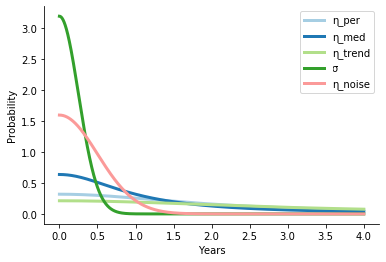

In [57]:
x = np.linspace(0, 4, 5000)
priors = [
    ("η_per",   pm.HalfCauchy.dist(beta=2)),
    ("η_med",   pm.HalfCauchy.dist(beta=1.0)),
    ("η_trend", pm.HalfCauchy.dist(beta=3)), # will use beta=2, but 2.2 is visible on plot
    ("σ",       pm.HalfNormal.dist(sigma=0.25)),
    ("η_noise", pm.HalfNormal.dist(sigma=0.5))]

colors = sns.color_palette('Paired', 5)
fig, ax = plt.subplots()
ax.set_ylabel('Probability')
ax.set_xlabel('Years')

for i, prior in enumerate(priors):
    y = np.exp(prior[1].logp(x).eval())
    ax.plot(x, y, label=prior[0],
           lw=3, color=colors[i])

ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# PYMC Model

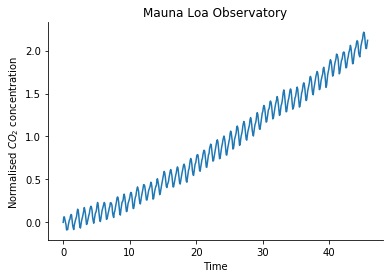

In [58]:
# pull out normalized data
t = data_early["t"].values[:,None]
y = data_early["y_n"].values

fig, ax = plt.subplots()
ax.plot(t, y);

ax.set_xlabel('Time')
ax.set_ylabel('Normalised $CO_2$ concentration')
ax.set_title('Mauna Loa Observatory')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [ ]:
def init_GP_seasonal():
    """
    Covariance: 
    - period_scale**2 * Periodic(periodic_smoothness) * Matern(periodic_decay)
    """
    # yearly periodic component x long term trend
    η_per = pm.HalfCauchy("η_per", beta=2, testval=1.0)
    ℓ_pdecay = pm.Gamma("ℓ_pdecay", alpha=10, beta=0.075)
    period  = pm.Normal("period", mu=1, sigma=0.05)
    ℓ_psmooth = pm.Gamma("ℓ_psmooth ", alpha=4, beta=3)
    cov_seasonal = η_per**2 * pm.gp.cov.Periodic(1, period, ℓ_psmooth) * pm.gp.cov.Matern52(1, ℓ_pdecay)
    gp_seasonal = pm.gp.Marginal(cov_func=cov_seasonal)

    return gp_seasonal
    

def init_GP_trend():
    """
    Covariance: 
    - trend_scale**2 * Exponential(trend_lengthscale)
    """
    # long term trend
    η_trend = pm.HalfCauchy("η_trend", beta=2, testval=2.0)
    ℓ_trend = pm.Gamma("ℓ_trend", alpha=4, beta=0.1)
    cov_trend = η_trend**2 * pm.gp.cov.ExpQuad(1, ℓ_trend)
    gp_trend = pm.gp.Marginal(cov_func=cov_trend)

    return gp_trend
    

def init_GP_medium():
    """
    Covariance: 
    - medium_scale**2 *RationalQuadratic(lengthscale, shape)
    """
    # small/medium term irregularities
    η_med = pm.HalfCauchy("η_med", beta=0.5, testval=0.1)
    ℓ_med = pm.Gamma("ℓ_med", alpha=2, beta=0.75)
    α = pm.Gamma("α", alpha=5, beta=2)
    cov_medium = η_med**2 * pm.gp.cov.RatQuad(1, ℓ_med, α)
    gp_medium = pm.gp.Marginal(cov_func=cov_medium)
    
    return gp_medium
    

def init_noise():
    """
    Covariance: 
    - noise_scale**2 * Matern32(noise_lengthscale) + WhiteNoise(noise_scale)
    """
    # noise model
    η_noise = pm.HalfNormal("η_noise", sigma=0.5, testval=0.05)
    ℓ_noise = pm.Gamma("ℓ_noise", alpha=2, beta=4)
    σ = pm.HalfNormal("σ",  sigma=0.25, testval=0.05)
    cov_noise = η_noise**2 * pm.gp.cov.Matern32(1, ℓ_noise) + pm.gp.cov.WhiteNoise(σ)

    return cov_noise
    

with pm.Model() as model:
    gp_seasonal = init_GP_seasonal()
    gp_trend = init_GP_trend()
    gp_medium = init_GP_medium()

    # The Gaussian process is a sum of these three components
    gp = gp_seasonal + gp_medium + gp_trend

    # Since the normal noise model and the GP are conjugates, we use `Marginal` with the `.marginal_likelihood` method
    cov_noise = init_noise()
    y_ = gp.marginal_likelihood("y", X=t, y=y, noise=cov_noise)

    # this line calls an optimizer to find the MAP
    mp = pm.find_MAP(include_transformed=True)

logp = 971.4, ||grad|| = 471.46:   0%|          | 3/5000 [00:00<24:41,  3.37it/s]

In [ ]:
mp

# Why GPs?
- finding an unknown variable in the space of continuous functions
- draw from a multivariate normal distribution that is parameterized by the mean function, 𝑚(𝑥), and the covariance function, 𝑘(𝑥,𝑥′)
- 